+----+----------+--------------------------+-------------------------------+-------------------+--------------------+-------------------+--------------------+-------------+----------------+----------------+------------------+----------------+----------------+-------------+----------------+-------------------+------------------+----------------+-----------------------------+------------------+---------------+-----------------+-------------+--------------+--------------+------------+---------------+-------------------+-------------------------+----------+------------------------+---------------------+--------------------------+---------------+--------------------------+-------------------------+---------------------+--------+------------------+------------------------+----------------+-----------------------+-----------------+---------------+-----------------+---------------------+---------------------+---------------------------------------------+--------------+---------------+---------

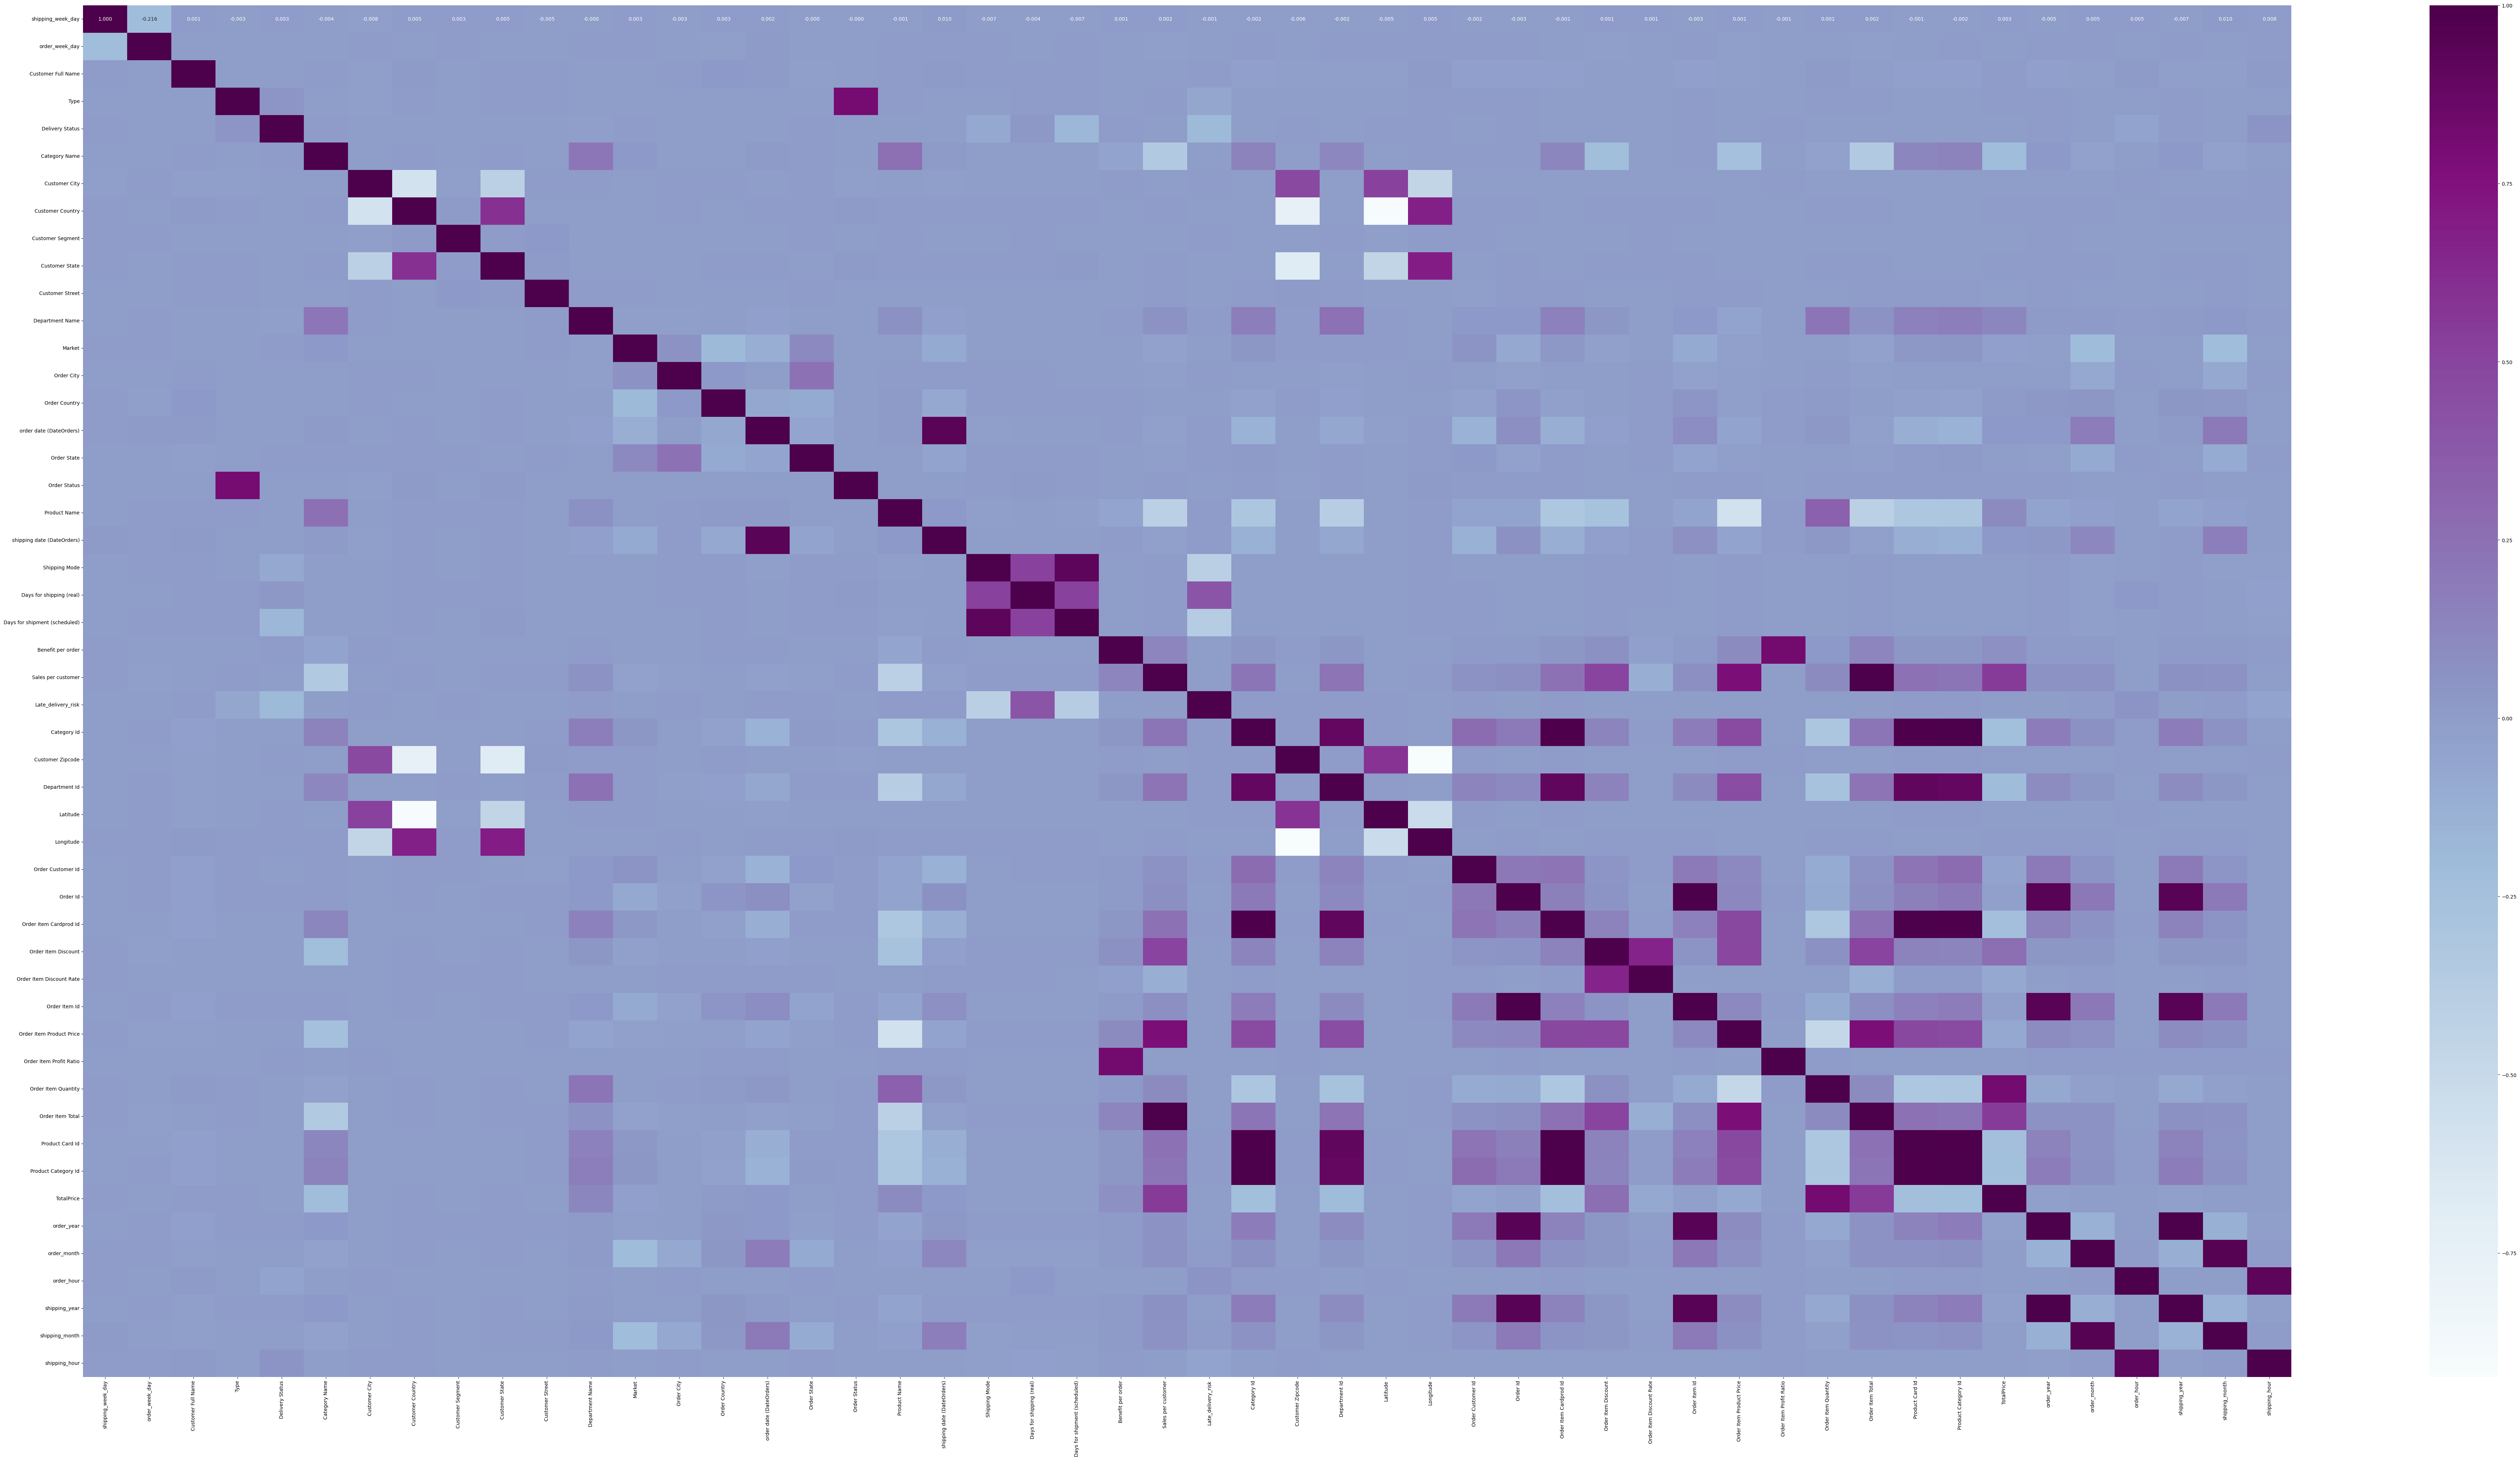

    shipping_week_day  order_week_day  Customer Full Name  Type  Delivery Status  Category Name  Customer City  Customer Country  Customer Segment  Customer State  Customer Street  Department Name  Market  Order City  Order Country  order date (DateOrders)  Order State  Order Status  Product Name  shipping date (DateOrders)  Shipping Mode  Days for shipping (real)  Days for shipment (scheduled)  Benefit per order  Sales per customer  Late_delivery_risk  Category Id  Customer Zipcode  Department Id   Latitude   Longitude  Order Customer Id  Order Id  Order Item Cardprod Id  Order Item Discount  Order Item Discount Rate  Order Item Id  Order Item Product Price  Order Item Profit Ratio  Order Item Quantity  Order Item Total  Product Card Id  Product Category Id   TotalPrice  order_year  order_month  order_hour  shipping_year  shipping_month  shipping_hour           Region
0                   2               6                1875     1                0             40             66        

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import svm,metrics,tree,preprocessing,linear_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import Ridge,LinearRegression,LogisticRegression,ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor,BaggingClassifier,ExtraTreesClassifier
from sklearn.metrics import accuracy_score,mean_squared_error,recall_score,confusion_matrix,f1_score,roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from tensorboardX import SummaryWriter
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate


# Hiding the warnings
warnings.filterwarnings('ignore')

dataset =pd.read_csv('/Users/yunbo-max/Desktop/Personalised_FL/Demand-Forecasting-with-PFL-methods/Explotary data analysis/Original Data/DataCoSupplyChainDataset.csv',encoding='latin-1')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print(tabulate(dataset.head(30), headers='keys', tablefmt='pretty'))


dataset['Customer Full Name'] = dataset['Customer Fname'] + dataset['Customer Lname']
dataset['TotalPrice'] = dataset['Order Item Quantity'] * dataset[
    'Sales per customer']  # Multiplying item price * Order quantity

data = dataset.drop(
    ['Customer Email', 'Customer Id', 'Customer Password', 'Customer Fname', 'Customer Lname',
      'Product Description', 'Product Image', 'Order Zipcode','Product Status','Order Profit Per Order','Product Price'], axis=1)

data['Customer Zipcode'] = data['Customer Zipcode'].fillna(0)  # Filling NaN columns with zero



data['order_year'] = pd.DatetimeIndex(data['order date (DateOrders)']).year
data['order_month'] = pd.DatetimeIndex(data['order date (DateOrders)']).month
data['order_week_day'] = pd.DatetimeIndex(data['order date (DateOrders)']).day_name()
data['order_hour'] = pd.DatetimeIndex(data['order date (DateOrders)']).hour
# data['order_second'] = pd.DatetimeIndex(data['order date (DateOrders)'])

data['shipping_year'] = pd.DatetimeIndex(data['shipping date (DateOrders)']).year
data['shipping_month'] = pd.DatetimeIndex(data['shipping date (DateOrders)']).month
data['shipping_week_day'] = pd.DatetimeIndex(data['shipping date (DateOrders)']).day_name()
data['shipping_hour'] = pd.DatetimeIndex(data['shipping date (DateOrders)']).hour

label_data = data[['shipping_week_day','order_week_day','Customer Full Name','Type','Delivery Status','Category Name','Customer City','Customer Country','Customer Segment','Customer State','Customer Street','Department Name','Market','Order City','Order Country','order date (DateOrders)','Order State','Order Status','Product Name','shipping date (DateOrders)','Shipping Mode']]

division = pd.DataFrame()
division['Region'] = data['Order Region']

target=data['Sales']

data=data.drop(columns=['shipping_week_day','order_week_day','Customer Full Name','Sales','Type','Delivery Status','Category Name','Customer City','Customer Country','Customer Segment','Customer State','Customer Street','Department Name','Market','Order City','Order Country','order date (DateOrders)','Order Region','Order State','Order Status','Product Name','shipping date (DateOrders)','Shipping Mode'])


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(tabulate(data.head(30), headers='keys', tablefmt='pretty'))
print(data.shape)

def Labelencoder_feature(x):
    le=LabelEncoder()
    x=le.fit_transform(x)
    return x

# Apply label encoding to remaining columns
data_encoded = label_data.apply(Labelencoder_feature)

data = pd.concat([data_encoded, data], axis=1)


# Calculate correlation matrix
correlation_matrix = data.corr()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(data.head(100))
print(data.shape)



# Create heatmap
plt.figure(figsize=(100, 50))
sns.heatmap(correlation_matrix, annot=True, fmt=".3f", cmap="BuPu")
plt.show()






data1 = pd.concat([data,division], axis=1)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(data1.head(100))
print(data1.shape)



In [6]:
#Feature Selection based on importance
from sklearn.feature_selection import f_regression
F_values, p_values  = f_regression(data, target)

import itertools
f_reg_results = [(i, v, z) for i, v, z in itertools.zip_longest(data.columns, F_values,  ['%.3f' % p for p in p_values])]
f_reg_results=pd.DataFrame(f_reg_results, columns=['Variable','F_Value', 'P_Value'])

f_reg_results=pd.DataFrame(f_reg_results, columns=['Variable','F_Value', 'P_Value'])
f_reg_results = f_reg_results.sort_values(by=['P_Value'])
f_reg_results.P_Value= f_reg_results.P_Value.astype(float)
f_reg_results=f_reg_results[f_reg_results.P_Value<0.06]
print(f_reg_results)

f_reg_list=f_reg_results.Variable.values
print(f_reg_list)

data_final=data1[['Order Id', 'Order Customer Id', 'Order Item Id',
 'Order Item Product Price' ,'Department Id',
 'Category Id' ,'shipping_month' ,'Benefit per order' ,
 'Product Card Id', 'Product Name', 'Order Item Cardprod Id' ,
 'Order State', 'Product Category Id', 'order_week_day', 'shipping_year',
 'Category Name', 'order_month', 'order_year' ,'Order Item Discount',
 'Department Name', 'Market', 'Order City',
 'Days for shipment (scheduled)' ,'Customer Segment', 'Customer Full Name','Region']]


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(data_final.head(100))
print(data_final.shape)



                         Variable       F_Value  P_Value
61               Order Item Total  8.665299e+06    0.000
53                       Order Id  1.157925e+03    0.000
26                  Category Name  2.606633e+04    0.000
60            Order Item Quantity  2.068679e+03    0.000
58       Order Item Product Price  2.996046e+05    0.000
57                  Order Item Id  1.133744e+03    0.000
32                Department Name  5.240946e+02    0.000
33                         Market  2.409108e+02    0.000
69                 shipping_month  5.764518e+02    0.000
62                Product Card Id  1.091556e+04    0.000
36        order date (DateOrders)  1.284620e+02    0.000
39                   Product Name  3.775172e+04    0.000
40     shipping date (DateOrders)  1.426521e+02    0.000
55            Order Item Discount  1.112179e+05    0.000
44              Benefit per order  3.192008e+03    0.000
45             Sales per customer  8.665299e+06    0.000
47                    Category 

In [30]:
import pandas as pd
import torch
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt

data = data1
# Extract unique 'Region' values to create different graphs
unique_regions = data['Region'].unique()

# Initialize a list to store the PyTorch Geometric Data objects and networkx graphs
graph_data_list = []
networkx_graphs = []

# Create graphs for each 'Region'
for region in unique_regions:
    # Filter data for the current 'Region'
    region_data = data[data['Region'] == region]

    # Count unique cities in 'Customer City' and 'Order City'
    unique_cities = list(set(region_data['Customer City']) | set(region_data['Order City']))

    # Create a mapping of city names to node indices
    city_to_index = {city: i for i, city in enumerate(unique_cities)}

    # Create a PyTorch Geometric Data object for the current 'Region'
    # Create nodes for 'Customer City' and 'Order City'
    num_nodes = len(unique_cities)
    x = torch.arange(num_nodes, dtype=torch.float).view(-1, 1)

    # Create edge indices
    edge_index = []
    for _, row in region_data.iterrows():
        start = city_to_index[row['Customer City']]
        end = city_to_index[row['Order City']]
        edge_index.extend([[start, end], [end, start]])  # Adding edges in both directions

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create a PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index)

    # Store the Data object and a networkx graph for visualization
    graph_data_list.append(data)

    G = nx.Graph()
    for i in range(data.num_nodes):
        G.add_node(i)

    for start, end in data.edge_index.t().tolist():
        G.add_edge(start, end)

    networkx_graphs.append(G)

# Visualize the graphs using networkx and matplotlib
for i, G in enumerate(networkx_graphs):
    plt.figure(i)
    pos = nx.spring_layout(G)  # Example layout
    nx.draw(G, pos, with_labels=True, node_color='b', node_size=500, font_size=10, font_color='k', font_weight='bold')
    plt.title(f'Graph for Region {unique_regions[i]}')
    plt.show()


TypeError: unhashable type: 'Series'